# Simple NonNegative Least Squares Fit (NNLS) for fluorescence

The general idea of this notebook is to try the simplest things first. We start with some "trusted" spectra at 6 discrete wavelengths from tubes 1-3 that are assumed to be entirely due to emission of particles 1-3. We then postulate that other regions of interest (ROIs) can be approximated as a weighted sum of those spectra. This amounts to solving

$$ Ax=b $$

where $A$ is the 6x3 (spectra X species) array of spectral shapes, $x$ are the (3x1) unknown weights in each ROI, and $b$ is the provided spectrum (6x1) in the given ROI. We use `nnls` from `scipy.optimize` to do the least squares inversion.

To get started, create a conda environment and install spectrochempy 

and install these four well-known modules: 

```> pip install numpy matplotlib pandas scipy```

and follow the more complicated [instructions for installing `spectrochempy`](https://www.spectrochempy.fr/latest/gettingstarted/install/index.html) via conda (pip did not work for me).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import nnls
import spectrochempy as scp

"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABgAAAAYCAYAAADgdz34AAAAAXNSR0IArs4c6QAAAAlw SFlzAAAJOgAACToB8GSSSgAAAetpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6 bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDUuNC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8x OTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAg eG1sbnM6eG1wPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMu YWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDx4bXA6Q3JlYXRvclRvb2w+bWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBo dHRwOi8vbWF0cGxvdGxpYi5vcmcvPC94bXA6Q3JlYXRvclRvb2w+CiAgICAgICAgIDx0aWZmOk9yaWVudGF0aW9uPjE8L3RpZmY6 T3JpZW50YXRpb24+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4bXBtZXRhPgqNQaNYAAAGiUlE QVRIDY1We4xU1Rn/3XPuYx47u8w+hnU38hTcuoUEt/6D2y4RB0ME1BoEd9taJaKh9CFiN7YGp7appUAMNmktMZFoJTYVLVQ0smsy 26CN0SU1QgsuFAaW3WVmx33N677O6XfuyoIxTXqSO/fec+75fd93vt/3/UbDV0aKSZmCpkFMLz3T9utuu2N+o98aDSMBKVAo89z5 y+zEz3ZafcCOfvWdlGCalqKn1Bf71CygTd+mf1esSOnpdMpTb+vWpTZuWVfe3jLPa5tzHYNm0T5N0gpdkkHaDBeGBU6d1/t/fyS8 +/CbqdfUvmsx1PuMgc2bNxv79u1zgd31r+7JH1jbIZKxWRXAcYUQ8IWvBfBXNjEuJWPgMA02NR7C3/pYT9fjdZ3A9tGrWF8YSJHn qcDz3y7q2T967PZv+gnYJdd1mEZ+62zGDQV/dQgKhmLzDNOXCEWM3j6eTT5Y3w78dOBKJLR1PQf+4ivPj76UPZnssBN+wbM9Aet/ AV81Mf1EEULXYfOobvX2WWQk0aoioXwwSmirOlioY0mu8BIouzYl7P8GV3vpqCCEZvlFz769w08oLDWvyKIyL1asSm28d6WfzA97 ztvvV1kexUMsmhlkULEkuGYmFYC6AvfUrITnwUKl5K79lkjeSSRRTCTbQPd95e1WzMbZSya74XoXAxctCllCnbECMOjZNGRwvzIX nD85wbkMmKK+U045Dtdi8Qp+SAxU2GTg2bYlC9224pgvmSb54vkVTBQYyhUt2KjAMyMmPjwRQW5Mh2WKwJhlBh6jVGagFM84wZnQ 4bpC0Rt4pk1PbSt0NDcxDA5xryosDHWgtbM0DGZDWLSoiDMDYeQnGVrmOThxLozB0RAaahzkJzjKNqcIQBymJFMkOlN8Dqjpg0XY Tx5xO/QbmmUrqIjGJznq47TqTaClKYfjp+PInLMwnOdYvtQBZ2XcunQY+VwIo4U4muoFEjVEFE6lQyEUKzHYfgQG9ylCyngU+Cxj tOqxCDGHcCsOMCs6iQul5ZiStdATYxjMZXDLTUVwLY8Jey4uOh2IxjwsrP8UXJYxUrkZrghBahzV5iXU6gNkq0Z1EzIsUBUSCV2n EOHo0LVxHCpuxabJJdhi5PFnvw5vLXwXIfNZvD/+JNo/X40NegE54sUaazl+UL8XD1x+FB9Ijjt4EQfdGN6J/x131LwIV9ap/AYs 0x1fz1ZKFbh6A7qKy/By9Dg6G36Ep91vUJJ15Cqr0Z67E8/HzmBrw1OwxWyM+3Mo6BAuSB17oyfx0Oyl2DN0Hqs/70Cx6hBCvESF UY1ShWXZZEE7OTAYxZzaPH4TuoiusZvRnunFy2NbiHYuBp2vB66srX4vMEjpRKPxKXmnoQ4+Mn4DPiv8CYcrs3GfNUXJLtM+alSO hrMj/KT+wBNW3+E/2liywNO3iSflbaFva/+stGDTxE0E9Sjaox8HBhxpEamzMGSEaFKg+mjEddzDh1MxTDq3YV1kGBsjfwW3S9Cq anjmko+ndlb1UR3s6K8JlfphNWq9Ew/7c61T2BB/EbcaNkb8GBaE0tANH7/M34PLdhJDzjIcL9xPbdTG6zyM72Y+wXPHmvB489No fm0b5HnbQ9Rgp/7DSSd29AeVvPeNyK6JcYl/yQVi5dBjuGvoV/gaJe47s45QUxrDmcYX0MBsdF7egvXZ7+O0vZA4X8QmOQWjlSK7 RDz5wIM30gp9UbWcGjXxhzdDu1SiNSpx6kcQB57rPnr/3dlkZarWLnlRq5oPET1dOCIOk4wALib9eeS5iygfhkd09H0DWphB/+gs +PcOAS+ssrFmmXXgVfR0de9cpbAJfH3Q1jofW9DZk56dDcVsq9YcsoUMEd1qyLoT3BX1YiyHMJuk97hyjqIoE91t+NcTLeN0ZrfM oXatZbu6G0h4VG+ibqq0IJVK6cAjo6serG3vSUezCMct0yQeSOFJSUImqb2qbknUpDqlZxE0QZ+ZUpSlZx79h4Nda6zef9dlk121 JDjbR5XggPRZlRnS6bRQRtLpn4++cuie/Yvn2svmNxuLw9WCcYIl4fEoTEGiSTUqJdfgU+8ROqf1iMkLzS389YtNPXc/PH8l8ONB JZkHD+4JtD04HmVEDWWErmBhzV2/2LB1bemJG6krzv2S6NOHUgtEP0Oif5pE/3fHoruP7N8RiP61GArzSwbUhJJQpXJKiKbfr/3b IhKq76sKPUdF9NW/LSqfSn6vjv8C45H/6FSgvZQAAAAASUVORK5CYII=' style='height:25px; border-radius:12px; display:inline-block; float:left; vertical-align:middle'>",SpectroChemPy's API - v.0.6.7© Copyright 2014-2023 - A.Travert & C.Fernandez @ LCS


### Set up the $A$ matrix

These are the guessed spectra for each species. I added a background "constant" spectrum just to see if it would remove some noise.

          Tube1    Tube2    Tube3  water
BP1100  1423.39   106.93   338.49    -20
BP1150  1141.72   355.45    65.13   -100
BP1300   228.56  1436.32   119.99   -135
BP1350    88.83   763.09   344.86   -390
BP1500     2.69    31.24  1149.40  -2000
BP1550     5.32    34.49  1393.15  -1000
(6, 4)
Index(['BP1100', 'BP1150', 'BP1300', 'BP1350', 'BP1500', 'BP1550'], dtype='object')
Index(['Tube1', 'Tube2', 'Tube3', 'water'], dtype='object')
(6, 3)
(5, 4)


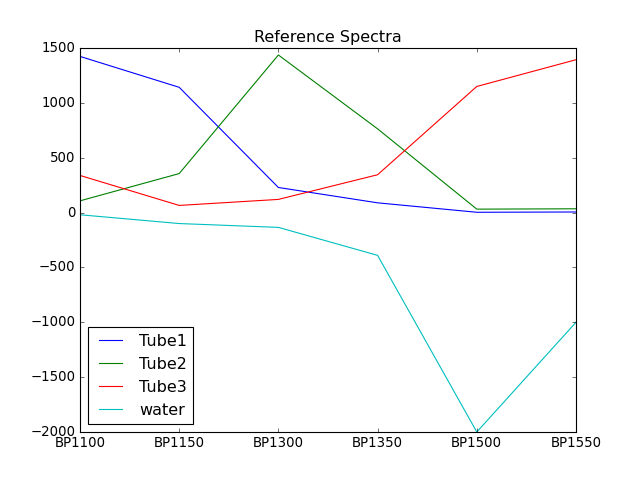

In [23]:
df_ref = pd.DataFrame({ 'Tube1': [1423.39, 1141.72, 228.56, 88.83, 2.69, 5.32],
                        'Tube2': [106.93, 355.45, 1436.32, 763.09, 31.24, 34.49],
                        'Tube3': [338.49, 65.13, 119.99, 344.86, 1149.40, 1393.15],
                        'water': [-20, -100, -135, -390, -2000, -1000]})
df_ref.index=('BP1100', 'BP1150', 'BP1300', 'BP1350', 'BP1500', 'BP1550')

print(df_ref)
print(df_ref.shape)
print(df_ref.index)
print(df_ref.columns)

A = df_ref.to_numpy()
df_ref.plot(title="Reference Spectra")

A = df_ref.drop(columns=['water']).to_numpy()
print(A.shape)
A = df_ref.drop(index=['BP1100']).to_numpy()
print(A.shape)

### Set up some ROIs

We can choose each of these to act as $b$ in $Ax=b$, but we presumably already have a feel for what species are present in each of these ROIs. 

           LN11  axialLN  inguinalLN  inguinaldrain    blood    liver
BP1100  1470.80  2024.43      687.53         622.79   950.06  2269.90
BP1150   945.80  1411.94      707.53         337.08   285.12   671.92
BP1300   873.39   970.24     2577.45        1279.45  1252.32  2797.94
BP1350  1074.45   776.86     2087.88        1185.42  1896.81  3048.42
BP1500   923.13   362.39      819.66         908.93  1840.96  2951.88
BP1550  1365.31   613.87     1318.48        1429.32  2420.01  3135.33


<Axes: title={'center': 'Mouse ROI Example Spectra'}>

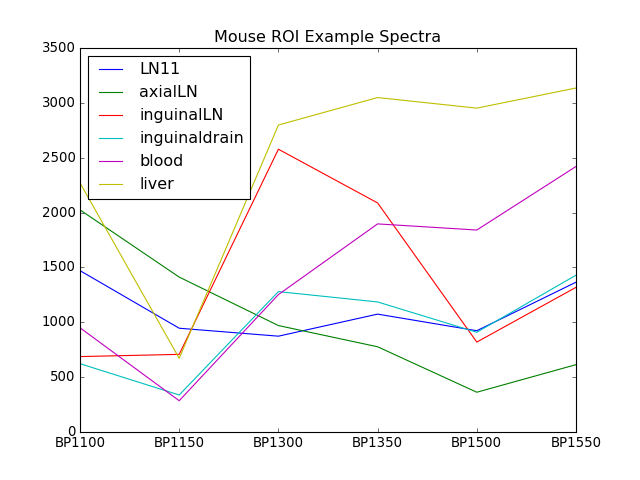

In [27]:
df = pd.DataFrame({'LN11': [1470.80, 945.80, 873.39, 1074.45, 923.13, 1365.31],
                   'axialLN': [2024.43, 1411.94, 970.24, 776.86, 362.39, 613.87],
                   'inguinalLN': [687.53, 707.53, 2577.45, 2087.88, 819.66, 1318.48],
                   'inguinaldrain': [622.79, 337.08, 1279.45, 1185.42, 908.93, 1429.32],
                   'blood': [950.06, 285.12, 1252.32, 1896.81, 1840.96, 2420.01],
                   'liver': [2269.90, 671.92, 2797.94, 3048.42, 2951.88, 3135.33]})
df.index=('BP1100', 'BP1150', 'BP1300', 'BP1350', 'BP1500', 'BP1550')
print(df)
df.plot(title="Mouse ROI Example Spectra")

In [32]:
# *** Choose a label from the above dataframe ***
y = df.axialLN.to_numpy()

# Solve the least squares problem to find the weights
w, res = nnls(A, y)

# Print the results
print(w)
print(res)

[   1.175    0.496   0.5898   0.1713]
241.98164840910246


Well, that seemed to work OK! Try playing around with different columns / ROIs on the first line of the above cell.

Next, we'll apply an NNLS fit to all the columns using the `apply` functionality from `pandas` and `axis=1` to indicate that we are applying the function over each column.

<Axes: title={'center': 'Predicted Data'}>

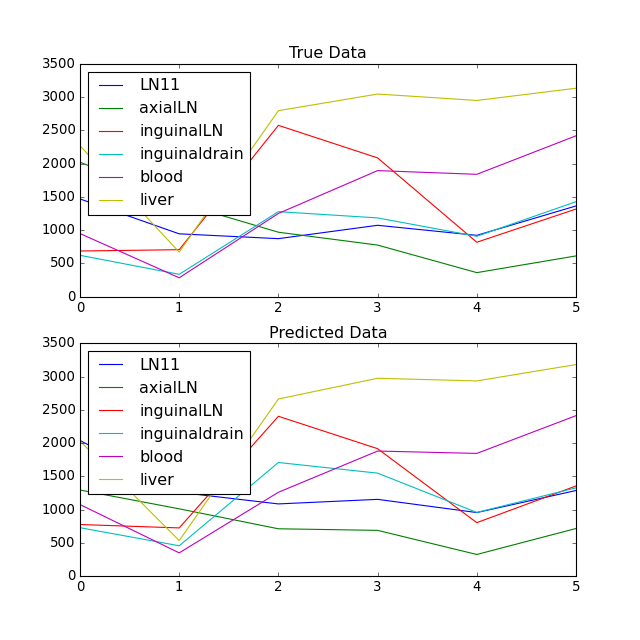

In [33]:
#Apply the nnls fit to each column in the dataframe
weights = df.apply(lambda b: nnls(A, b)[0], axis=1)

# Create the predicted output from those weights to compare
yhats = np.zeros(df.shape)
for i, w in enumerate(weights):
   yhats[i] = np.matmul(A,w)

# Make a dataframe from the predicted output that uses the same columns as df
df_yhats = pd.DataFrame(yhats, index=df.index, columns=df.columns)

fig, ax = plt.subplots(2,1, figsize=(8,8))
df.plot(ax=ax[0], title="True Data")
df_yhats.plot(ax=ax[1], title="Predicted Data")

## Try the simple approach on the tubes image

(37152, 6)
(37152, 5)


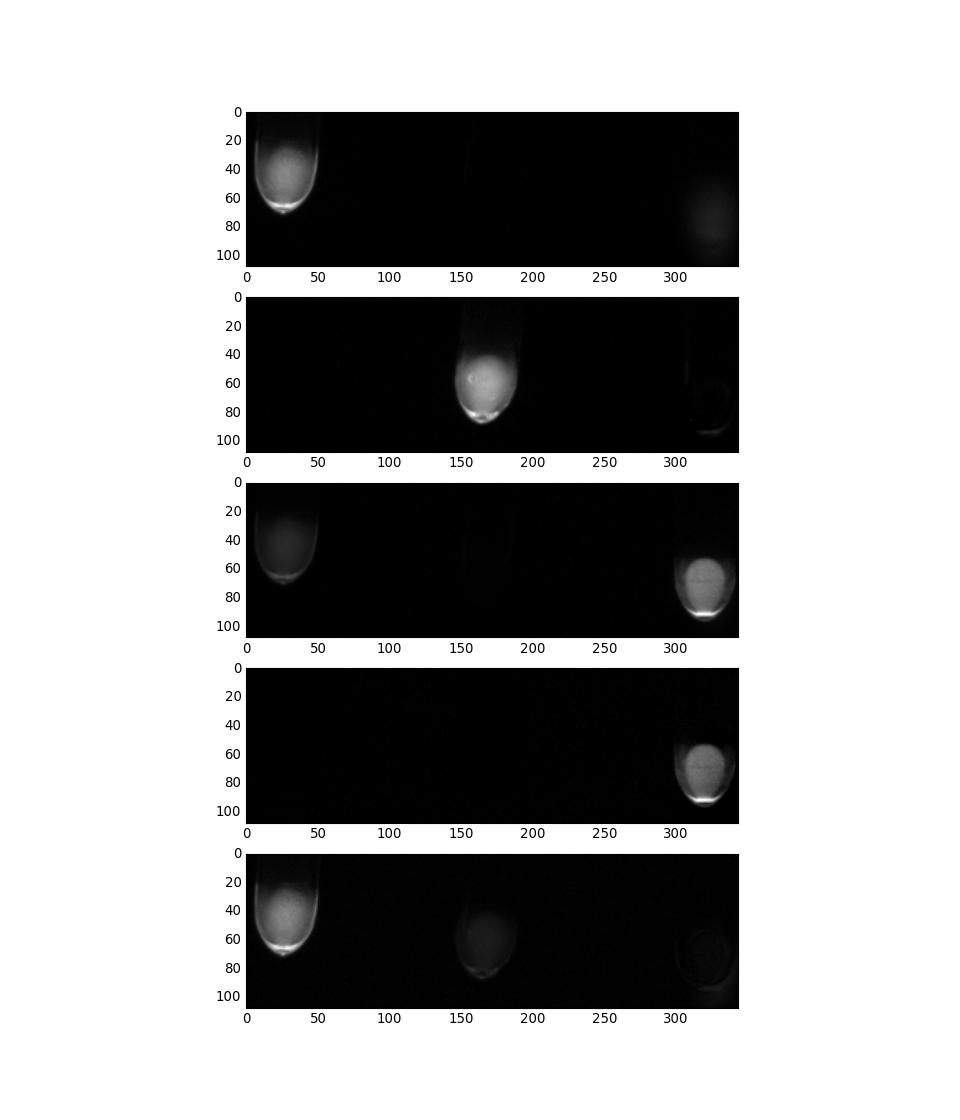

In [31]:
tube_array = np.load('../data/tube_input_matrix.npy')
print(tube_array.shape)
tube_array = np.delete(tube_array,0,1)
print(tube_array.shape)

# Apply a function across each row of the numpy array
tube_array_weights = np.apply_along_axis(lambda b: nnls(A,b)[0], 1, tube_array)
residuals = np.apply_along_axis(lambda b: nnls(A,b)[1], 1, tube_array)

tube_shape = (108,344)
# Convert the weights to an WxL image
sfig, ax = plt.subplots(5, figsize=(12,14))
As = np.reshape(tube_array_weights[:,0], tube_shape)
Bs = np.reshape(tube_array_weights[:,1], tube_shape)
Cs = np.reshape(tube_array_weights[:,2], tube_shape)
Ds = np.reshape(tube_array_weights[:,3], tube_shape)

Rs = np.reshape(residuals, tube_shape)
ax[0].imshow(As, cmap='gray')
ax[1].imshow(Bs, cmap='gray')
ax[2].imshow(Cs, cmap='gray')
ax[3].imshow(Ds, cmap='gray')
ax[4].imshow(Rs, cmap='gray')

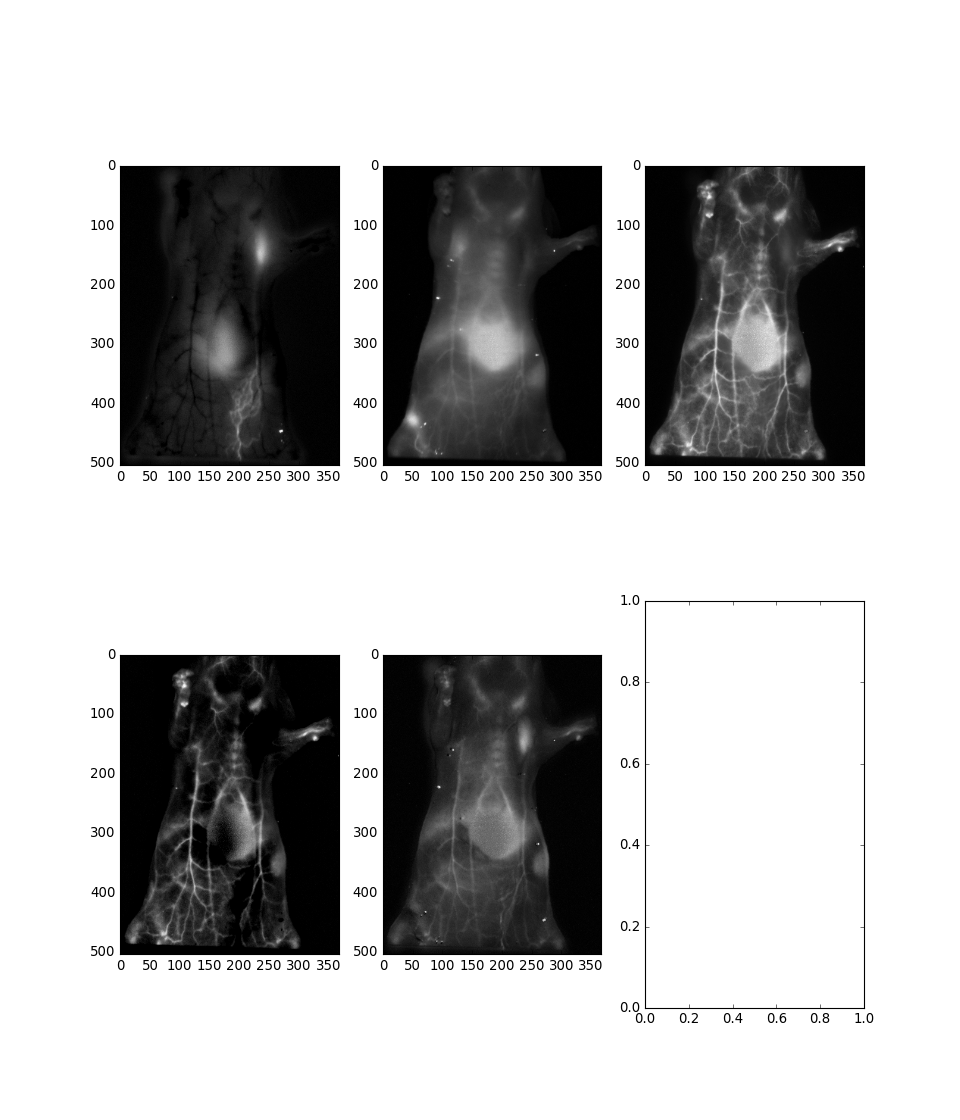

In [35]:
mouse_array = np.load('../data/mouse_input_matrix.npy')

# Apply a function across each row of the numpy array
mouse_array_weights = np.apply_along_axis(lambda b: nnls(A,b)[0], 1, mouse_array)
residuals = np.apply_along_axis(lambda b: nnls(A,b)[1], 1, mouse_array)

# Convert the weights to an WxL image
shape = (504,368)
fig, ax = plt.subplots(2,3, figsize=(12,14))
As = np.reshape(mouse_array_weights[:,0], shape)
Bs = np.reshape(mouse_array_weights[:,1], shape)
Cs = np.reshape(mouse_array_weights[:,2], shape)
Ds = np.reshape(mouse_array_weights[:,3], shape)
Rs = np.reshape(residuals, shape)
ax[0][0].imshow(As, cmap='gray')
ax[0][1].imshow(Bs, cmap='gray')
ax[0][2].imshow(Cs, cmap='gray')
ax[1][0].imshow(Ds, cmap='gray')
ax[1][1].imshow(Rs, cmap='gray')

In [32]:
plt.hist(Rs)

(array([[     108,        0, ...,        0,        0],
        [     108,        0, ...,        0,        0],
        ...,
        [     108,        0, ...,        0,        0],
        [     108,        0, ...,        0,        0]]),
 array([0.002994,    267.6, ...,     2408,     2676]),
 <a list of 344 BarContainer objects>)

## Spectra Optimization
So that worked alright, but now we want to see if we can change those 3 initial spectra from the tubes such that they do a better job of fitting the data overall -- you can see from the tube and mouse images that there is still a pretty large residual. To do that, we're going to use Alternating Least Squares. Essentially, we can go back and forth a bit, finding the coefficients for each pixel using NNLS, and then updating the spectra using NNLS.

We will try their solver first without including the water spectrum, as that appears to run well for the tubes and runs, but yields some artifacts with the mouse.
Subsequently, we'll work to adapt their solver to include the negative water spectra (use OLS instead of NNLS?)

In [25]:
## Make a function that takes in spectral data and returns the MCRALS object used in fitting
def fit_mcrals(np_file, St_guess):
    X = np.load(np_file)
    mcr = scp.MCRALS(log_level="INFO")
    mcr.fit(X,St_guess)
    return mcr

def make_image(ax_in, concentrations, reshape):
    ps = np.reshape(concentrations, reshape)
    ax_in.imshow(ps, cmap='gray')

 Spectra profile initialized with 4 components
 Initial concentration profile computed
 ***           ALS optimisation log            ***
 #iter     RSE / PCA        RSE / Exp      %change
 -------------------------------------------------
   1       41.669316       41.669316      -83.110237
   2       12.905515       12.905515      -69.028734
   3       13.960779       13.960779        8.176849
   4       13.963976       13.963976        0.022899
 converged !
 ERROR | TypeError: tuple indices must be integers or slices, not NDDataset


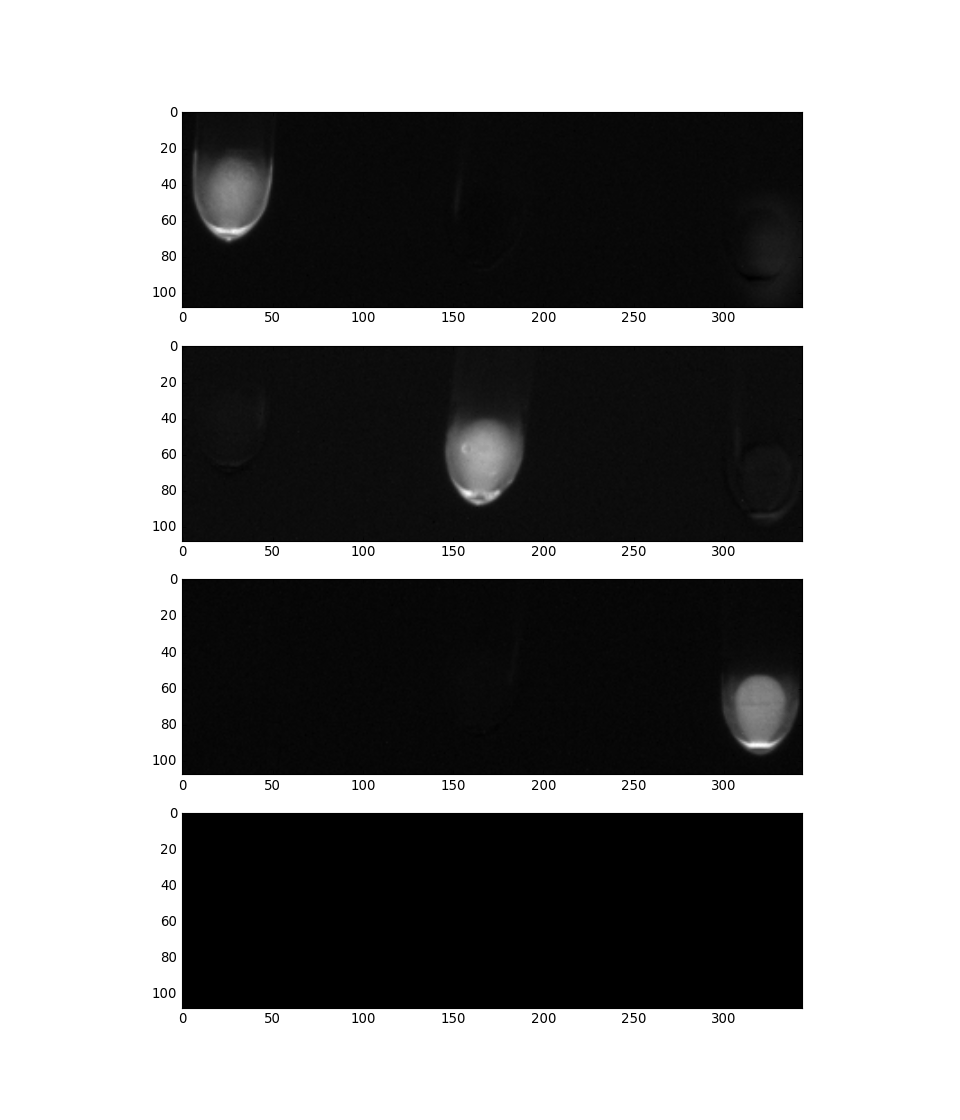

In [29]:
mcr_tube = fit_mcrals('../data/tube_input_matrix.npy', A.T)
tube_conc = np.array(mcr_tube.C)

tube_shape = (108,344)
# Convert the weights to an WxL image
sfig, ax = plt.subplots(4,1, figsize=(12,14))
make_image(ax[0], tube_conc[:,0], tube_shape)
make_image(ax[1], tube_conc[:,1], tube_shape)
make_image(ax[2], tube_conc[:,2], tube_shape)
make_image(ax[3], tube_conc[:,3], tube_shape)

shape[mcr_tube.C]

<_Axes: xlabel='values $\\mathrm{}$', ylabel='values $\\mathrm{}$'>

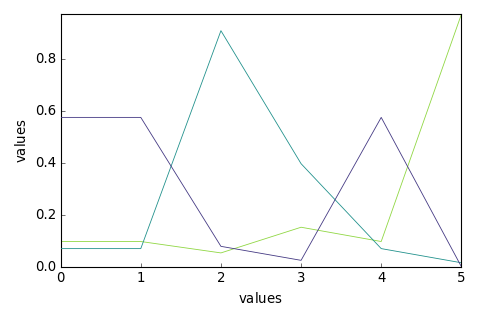

In [11]:
mcr_tube.St.plot()

 Spectra profile initialized with 3 components
 Initial concentration profile computed
 ***           ALS optimisation log            ***
 #iter     RSE / PCA        RSE / Exp      %change
 -------------------------------------------------
   1       70.232448       70.522904      -88.237747
   2       26.032833       40.970856      -41.904184
   3       21.809437       38.910629       -5.028520
   4       26.729221       41.644807        7.026815
   5       24.683075       40.209860       -3.445680
   6       25.256975       40.599538        0.969112
   7       25.030342       40.460823       -0.341668
   8       25.105364       40.507745        0.115969
   9       25.081130       40.492305       -0.038117
 converged !


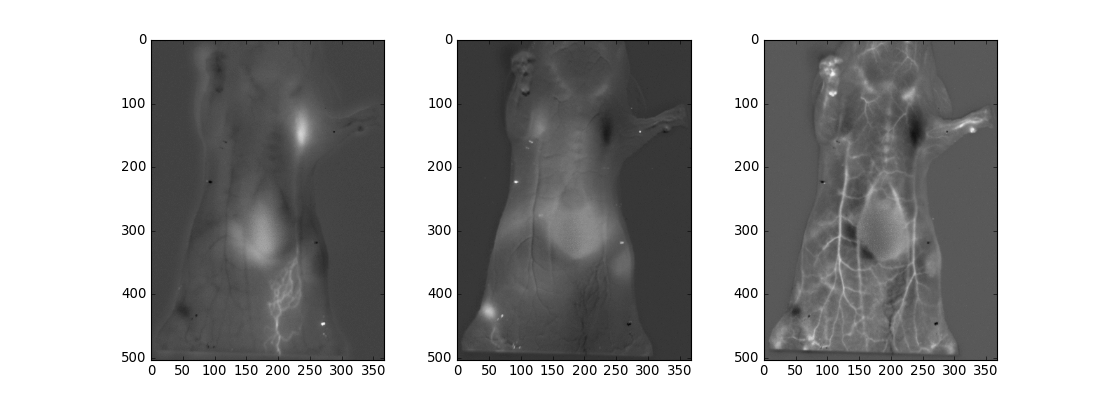

In [12]:

mcr_mouse = fit_mcrals('mouse_input_matrix.npy', A.T)
#mcr_mouse = fit_mcrals('mouse_input_matrix.npy', mcr_tube.St)
mouse_conc = np.array(mcr_mouse.C)

mouse_shape = (504,368)
# Convert the weights to an WxL image
sfig, ax = plt.subplots(1,3, figsize=(14,5))
make_image(ax[0], mouse_conc[:,0], mouse_shape)
make_image(ax[1], mouse_conc[:,1], mouse_shape)
make_image(ax[2], mouse_conc[:,2], mouse_shape)

<_Axes: xlabel='values $\\mathrm{}$', ylabel='values $\\mathrm{}$'>

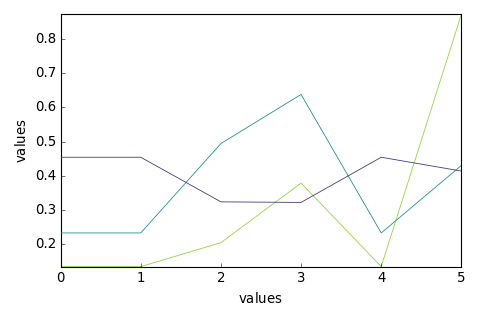

In [13]:
mcr_mouse.St.plot()